In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score, precision_score
from matplotlib import pyplot as  plt
from sklearn.externals import joblib
import concurrent.futures
import warnings, sys, glob
warnings.filterwarnings('ignore')

/home/rahulr/Documents/HW4 - docs/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def generate_data():
    """ 
        This function will generate random dataset from the file 'HW_TESLA.xlt' after clearning and splitting them into customary datasets
        such as X_train, y_train, X_test, y_test
  
        Parameters: 
            None 
          
        Returns: 
        
            Returns following Pandas DATAFRAME objects a tuple in the following order
            X_train, y_train, X_test, y_test
            
        """
    df = pd.read_excel('../HW_TESLA.xlt')
    le=LabelEncoder().fit_transform(df['STATIC'])
    df_train, df_test = train_test_split(df, test_size=0.25) # 75 % training data
    #Separating feature matrix and corresponding labels
    X_train = df_train.drop('STATIC',axis=1)
    X_test = df_test.drop('STATIC',axis=1)
    y_train = df_train['STATIC']
    y_test = df_test['STATIC']
    return X_train, y_train, X_test, y_test

In [3]:
def generate_report(conf_mat, y_test, y_pred):

    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)

    return FP, FN, accuracy, recall, precision, f1score

### Generating Dataset 

In [4]:
X_train, y_train, X_test, y_test = generate_data()

### Applying Decision Tree before PCA 

In [5]:
def DT_before_PCA():
    
    p_grid = {'criterion': ['gini','entropy'],
                   'max_depth': [2,3,4,5,6,7],
                   'min_samples_split':[2,3,4,5,10,20,50],
                   }
    clf = DecisionTreeClassifier()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=p_grid,
                             n_iter=100, cv = 3, n_jobs = -1, scoring='recall')
    clf_random.fit(X_train, y_train)
    #     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_random.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
#     save_model(outcome, DT_before_PCA)
#     print(clf_random.best_estimator_)
    return outcome, clf_random

### Calculating n_components in PCA for feature reduction

[51.1 90.2 97.8 99.7 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9 99.9
 99.9 99.9 99.9 99.9 99.9 99.9]


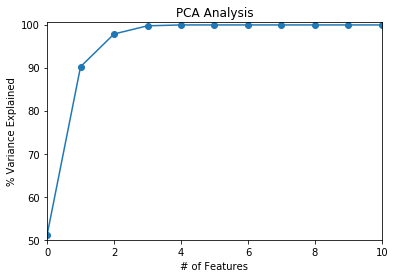

In [6]:
#Centering data by mean i.e. subtracting mean from each data and doing PCA
# X_train, y_train, X_test, y_test = generate_data()
scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


covar_matrix=PCA()
covar_matrix.fit(X_train)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
print(var) #cumulative sum of variance explained with [n] features

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(50,100.5)
plt.xlim(0,10)
plt.style.context('seaborn-whitegrid')


plt.plot(var, marker='o')

In [7]:
def apply_PCA(X_train, X_test):
    # we can reduce number of features to 5 to capture 99.8 % variance in PCA
    pca=PCA(n_components=5)
    pca.fit(X_train)

    # Get new feature matrices from pca
    pca_X_train=pca.transform(X_train)
    pca_X_test=pca.transform(X_test)
    return pca_X_train, pca_X_test

In [8]:
pca_X_train, pca_X_test = apply_PCA(X_train, X_test)

### Running Decision Tree Algorithm after PCA

In [9]:
def DT_after_PCA():
    scoring = ['accuracy', 'recall']
#     X_train, y_train, X_test, y_test = generate_data()
#     pca_X_train, pca_X_test = apply_PCA(X_train, X_test)
    

    p_grid = {'criterion': ['gini','entropy'],
               'max_depth': [2,3,4,5,6,7,8,9],
               'min_samples_split':[2,3,4,5],
               }

    clf = DecisionTreeClassifier()
    clf_gs = RandomizedSearchCV(estimator=clf, param_distributions=p_grid,
                                n_iter=100, cv = 3, n_jobs = -1, scoring='f1')
    clf_gs.fit(X_train, y_train)
    scores = cross_val_score(clf_gs, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_gs.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
#     save_model(outcome, DT_before_PCA)

#     print(clf_gs.best_estimator_)

    return outcome, clf_gs

### Running Logistic Regression after PCA

In [10]:
def LR_after_PCA():
#     X_train, y_train, X_test, y_test = generate_data()
#     pca_X_train, pca_X_test = apply_PCA(X_train, X_test)

#     scoring = ['accuracy', 'f1']
    p_grid = {'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
                   'C' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
                   'max_iter':[100,200,300],
                   
                  }
    
    clf = LogisticRegression()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=p_grid,
                                n_iter=100, cv = 3, n_jobs = -1, scoring='f1')
    clf_random.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
#     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=5)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
#     save_model(outcome, DT_before_PCA)

#     print(clf_random.best_estimator_)
    return outcome, clf_random

### Running Linear SVM after PCA

In [11]:
def SVM_after_PCA():
#     start = time.perf_counter()
#     X_train, y_train, X_test, y_test = generate_data()
    
#     p_grid = {
#                    'C' : [.2, .3, .4, .5, .6, .7, .8, .9, 1],
#                   'kernel': ['linear','poly','rbf','sigmoid'],
#                   'degree': [2,3,4],
#                   'gamma': ['scale','auto'],
#                   'decision_function_shape': ['ovo','ovr'],
#                   }
    p_grid = {
                   'C' : [.2, .3, .4, .5, .6, .7, .8, .9, 1],
                  'kernel': ['linear','poly','rbf','sigmoid'],
                  }
    
    clf = SVC()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=p_grid, 
                                    n_iter = 100, cv = 3, random_state=42, 
                                    n_jobs = -1, scoring='f1')
#     clf_gs = GridSearchCV(estimator=clf, param_grid=p_grid, 
#                                     cv = 3, n_jobs = -1, scoring='f1')
    clf_random.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
#     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=3)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    

    return outcome, clf_random
    

In [12]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

### Getting the report of different algorithms

In [17]:
def start_training(max_experiment=5):
    # algos = {'DT before PCA':DT_before_PCA,
    #          'DT with PCA':DT_after_PCA,
    #          'LR with PCA':LR_after_PCA,
    #          'SVM with PCA':SVM_after_PCA}

    algos = {'DT before PCA':DT_before_PCA,
             'DT with PCA':DT_after_PCA,
            }
    
    expected_accuracy = 0.997
    expected_FN = 2
    

    count = max_experiment # Experiment Count for overall analysis

    for c in progressbar(range(count), "Training progress: ", 20):
#         if 'DT with PCA_model.model' or 'DT before PCA_model.model' in glob.glob("*.model"):
#             break
#     for c in range(count):
        X_train, y_train, X_test, y_test = generate_data()        
        pca_X_train, pca_X_test = apply_PCA(X_train, X_test)
        print('\n')
        start = time.perf_counter()

        measurements = []
        for k in algos.keys():
            algo = algos[k]
            outcome, clf = algo()
            measurements.append(outcome)
            if outcome[3] > expected_accuracy and outcome[2] <= expected_FN: # outcome[2] -> False Negative and  outcome[3] -> Prediction Accuracy
                # Save the model for future use 
                filename = k + '_model.model'
                joblib.dump(clf, filename)


        print("\nRan the experiment with dataset no.", c+1)
        print("Report: \n")
        cols = ['Val_Accuracy', 'FP', 'FN', 'Accuracy', 'Recall', 'Precision', 'F1Score']

        df_outcome = pd.DataFrame(measurements, columns=cols)
        df_outcome.index = list(algos.keys()) 
        print(df_outcome)

        finish = time.perf_counter()
        print("Time Taken for execution is ", round(finish-start, 2), 'Seconds\n\n')
    if 'DT with PCA_model.model' or 'DT before PCA_model.model' not in glob.glob("*.model"):
        print('Experimented ', count,'times for attaining expected accuracy. Start training again for another try')
    print('Experiment Completed')

In [18]:
i = 1
while 'DT with PCA_model.model' or 'DT before PCA_model.model' not in glob.glob("*.model"):
    
    start_training()
    time.sleep(0.5)

Training progress: [....................] 0/5


Ran the experiment with dataset no. 1
Report: 

               Val_Accuracy  FP  FN  Accuracy    Recall  Precision   F1Score
DT before PCA      0.996798   5   4  0.991329  0.993750   0.992200  0.992974
DT with PCA        0.995457   4   2  0.994220  0.996875   0.993769  0.995320
Time Taken for execution is  15.18 Seconds


Training progress: [####................] 1/5


Ran the experiment with dataset no. 2
Report: 

               Val_Accuracy  FP  FN  Accuracy    Recall  Precision   F1Score
DT before PCA      0.995198   5   4  0.991329  0.993750   0.992200  0.992974
DT with PCA        0.995190   4   2  0.994220  0.996875   0.993769  0.995320
Time Taken for execution is  14.42 Seconds


Training progress: [########............] 2/5


Ran the experiment with dataset no. 3
Report: 

               Val_Accuracy  FP  FN  Accuracy    Recall  Precision   F1Score
DT before PCA      0.994665   5   3  0.992293  0.995313   0.992212  0.993760
DT wit

KeyboardInterrupt: 

In [ ]:
trained_model = joblib.load("DT with PCA_model.model")

In [ ]:
# if 'DT with PCA_model.sav' or 'DT before PCA_model.sav' in glob.glob("*.sav"):
#     print('yes')
    

### Testing stage for evaluation of the trained model!

In [ ]:
for _ in range(100):
    X_train, y_train, X_test, y_test = generate_data() # Generate random dataset 
    pca_X_train, pca_X_test = apply_PCA(X_train, X_test) # Apply PCA

    y_pred = trained_model.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)

    outcome = list(generate_report(conf_mat, y_test, y_pred))
    print(outcome)